In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz, plot_tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from IPython.display import Image
from io import StringIO
from sklearn.tree import export_graphviz
import pydotplus

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
HotelReview = pd.read_csv("/content/drive/MyDrive/BAP Project/Datasets/Final Datasets/Hotel_Cleaned.csv")
HotelTrain = pd.read_csv("/content/drive/MyDrive/BAP Project/Datasets/Final Datasets/train_set.csv")
HotelTest = pd.read_csv("/content/drive/MyDrive/BAP Project/Datasets/Final Datasets/test_set.csv")

In [ ]:
# Preprocess data for RandomForest
def data_preprocessing(df):
    df['Log_WordCount'] = np.log(df['Reviews_WordCount'])
    df = df.drop(['Hotel','Titles','Reviews','Dates','No_of_Reviews','Reviews_WordCount', 'Rating',
                  'Address','Sentiment_Pos','Sentiment_Neg','Sentiment_Neu','Sentiment','Year'], axis = 1)
    df = pd.get_dummies(df, columns = ['Travel_Type','Hotel_Class'],
                        drop_first = True)
    return df

In [ ]:
def randomforest_model(X_train, X_test, y_train, y_test, imagename):

    rf = RandomForestRegressor(random_state=42)

    param_grid = {
        "n_estimators": [50, 100, 200, 400],
        "max_depth": [2, 3, 5, 8, 10],
        "max_features": ["sqrt", "log2"]
    }

    grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    best_rf = grid_search.best_estimator_
    print("Best hyperparameters:", grid_search.best_params_)

    # Fit the model on the training data and make predictions on the test data
    best_rf.fit(X_train, y_train)
    y_pred = best_rf.predict(X_test)

    # Calculate the testing accuracy score
    test_score = best_rf.score(X_test, y_test)
    print("Accuracy Score:", test_score)

    # Calculate the evaluation metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    # Print the evaluation metrics
    print('R2:', r2)
    print('Root Mean Squared Error:', rmse)
    print('Mean Absolute Error:', mae)

    # Print the feature importance
    importances = best_rf.feature_importances_
    feature_importances = dict(zip(X_train.columns, importances))
    used_features = [feature for feature, importance in feature_importances.items() if importance > 0]

    X_train_selected = X_train[used_features]
    X_test_selected = X_test[used_features]

    # Print out the used features, their importances, and their coefficients
    print("\nFeatures used in the Model:")
    for feature, importance in feature_importances.items():
        if importance > 0:
            print(f"{feature}: {importance} ({best_rf.feature_importances_[X_train.columns.get_loc(feature)]})")

    # Create and save the random forest diagram
    plt.figure(figsize=(20,10))
    plot_tree(best_rf.estimators_[0], feature_names=X_train.columns,
              class_names=True, filled=True, rounded=True)
    plt.show()

    dot_data = StringIO()
    export_graphviz(best_rf.estimators_[0], out_file=dot_data,
                    filled=True, rounded=True,
                    special_characters=True,
                    feature_names=X_train.columns, max_depth=3) # Set to 3 to make it look clearer

    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    directory = '/content/drive/MyDrive/BAP Project/Codes/images/'
    filename = directory + imagename + '.png'
    graph.write_png(filename)


Best hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 400}
Accuracy Score: 0.4091974189494991
R2: 0.4091974189494991
Root Mean Squared Error: 0.34685070917977334
Mean Absolute Error: 0.207013039337388

Features used in the Model:
Review_Rating: 0.7881036094315761 (0.7881036094315761)
Location: 0.013114973598127156 (0.013114973598127156)
Cleanliness: 0.02885117493805969 (0.02885117493805969)
Service: 0.03560645034401429 (0.03560645034401429)
Value: 0.020519535850576334 (0.020519535850576334)
FreeParking: 0.0022883894937389656 (0.0022883894937389656)
FreeWifi: 0.0013439737806642009 (0.0013439737806642009)
FreeBreakfast: 0.0028624739478060567 (0.0028624739478060567)
Gym: 0.0033233235010070084 (0.0033233235010070084)
Pool: 0.002553919498831281 (0.002553919498831281)
Restaurant: 0.0028332900967004836 (0.0028332900967004836)
BarLounge: 0.006080018572189675 (0.006080018572189675)
TV: 0.0012387098915056498 (0.0012387098915056498)
EventFacilities: 0.00408073903234033 (

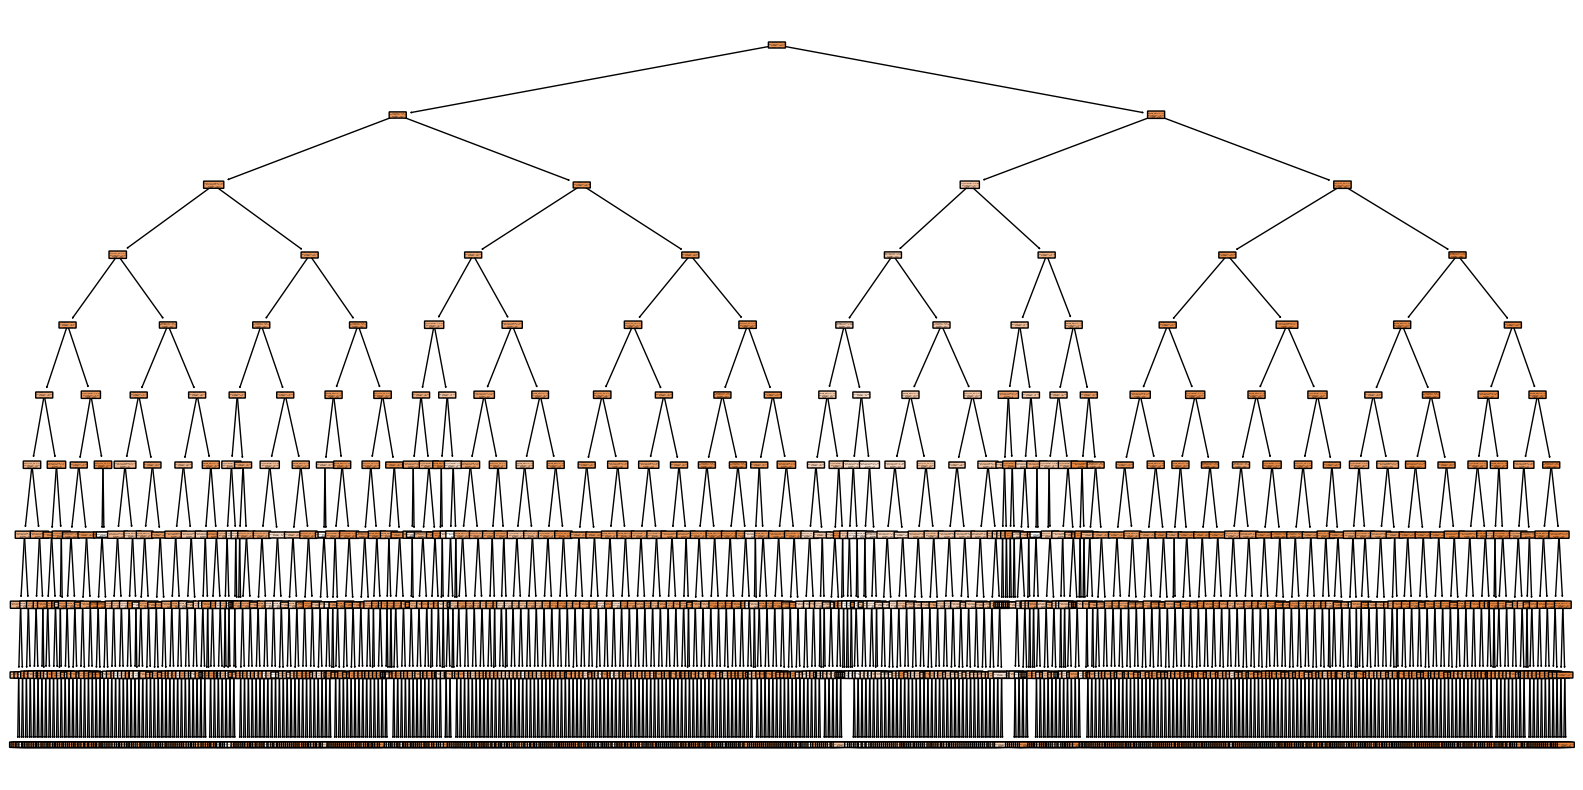

In [ ]:
HotelTrain_Processed = data_preprocessing(HotelTrain)
HotelTest_Processed = data_preprocessing(HotelTest)

y_train = HotelTrain_Processed['Sentiment_Compound']
x_train = HotelTrain_Processed.drop(['Sentiment_Compound'], axis = 1)
y_test = HotelTest_Processed['Sentiment_Compound']
x_test = HotelTest_Processed.drop(['Sentiment_Compound'], axis = 1)

randomforest_model(x_train, x_test, y_train, y_test, "RandomForest")